The goal of this notebook is to investigate the link between moment-matching formulae such as the Gauss-Hermite quadrature and discrete approximation of the normal distribution via a distance minimization problem in the space of probability measures endowed with a given distance. For simplicity, we consider only the toy problem of discretizing the normal distribution with a distribution supported by 2 points.

In [1]:
import numpy as np
from scipy.special import roots_hermitenorm
from scipy.optimize import minimize_scalar
from scipy.stats import norm, rv_discrete
from ot import wasserstein_1d
import matplotlib.pyplot as plt
import seaborn as sns

## 1D Gaussian cubature, n=2 (Gauss-Hermite formula)

The Gauss-Hermite cubature formula at order $n$ is obtained by matching the first moments of $\alpha = \mathcal{N}(0, \sigma^2)$ with those of a discrete probability measure $\beta = \sum_{i=0}^n w_i \delta_{x_i}$.

By symmetry of the normal distribution, the weights $(w_i)$ and knots $(x_i)$ are symmetric around zero. In the case $n=2$, this reduces the cubature measure to $\beta = \frac{1}{2} \delta_{-x_0} + \frac{1}{2} \delta_{x_0}$ for some $x_0\in \mathbb{R}_+$.

Below is the Gauss-Hermite grid for $n=2$. Note that indeed $\mathbb{E}[\beta] = 0$ and $\mathbb{V}[\beta] = 1$.

In [2]:
SIGMA = 3.0
knots, weights = roots_hermitenorm(2)
weights /= np.sqrt(2 * np.pi)
print('Knots: {}'.format(knots))
print('Weights: {}'.format(weights))

Knots: [-1.  1.]
Weights: [0.5 0.5]


## Wasserstein distance

The $p$-Wasserstein or optimal transport distance between $\alpha$ and $\beta$ is :

$$
W_p(\alpha, \beta) = \inf_{\gamma \in \Gamma(\alpha, \beta)} \big( \int_{0}^{+\infty} \lvert x-y \rvert^p d\gamma(x, y) \big)^{\frac{1}{p}}
$$
where $\Gamma(\alpha, \beta)$ is the set of couplings between the two distributions $\alpha$ and $\beta$, i.e the set of joint distributions with first marginal $\alpha$ and second marginal $\beta$.

Since we are working with 1D distribution and thanks to $\alpha$ being atomless, there exists a unique non-decreasing transport map $T$ such that (see Theorem 2.5 in [Filippo Santambrogio](https://www.imo.universite-paris-saclay.fr/~filippo/OTAM-cvgmt.pdf)):

$$
W_p(\alpha, \beta) = \big( \int_{0}^{+\infty} \lvert T(x) - x \rvert^p d\alpha(x) \big)^{\frac{1}{p}}.
$$

This map is given by $T = F^{-1}_{\beta}(F_\alpha)$, where $F_{\mu}$ is the cumulative distribution function (CDF) of measure $\mu$.

First, let's take a look at the CDF of the normal vs discrete distributions.

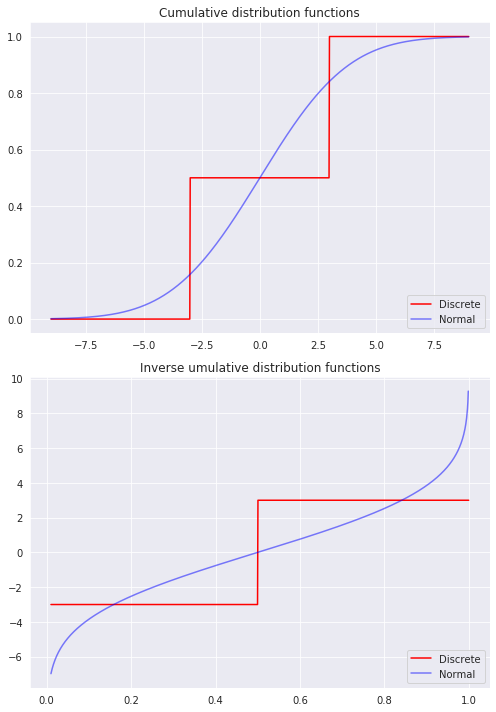

In [3]:
alpha = norm(loc=0.0, scale=SIGMA)
pk = (0.5, 0.5)
xk = (-SIGMA, SIGMA)
beta = rv_discrete(name='cubature', values=(xk, pk))

tt = np.linspace(-3 * SIGMA, 3 * SIGMA, 1000)
pp = np.linspace(0.01, 1.0, 1000)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(7, 10), nrows=2, ncols=1)
    
    ax = axes[0]
    ax.plot(tt, beta.cdf(tt), color='r', label='Discrete')
    ax.plot(tt, alpha.cdf(tt), color='b', alpha=0.5, label='Normal')
    ax.legend(loc='lower right')
    ax.set_title('Cumulative distribution functions')
    
    ax = axes[1]
    ax.plot(pp, beta.ppf(pp), color='r', label='Discrete')
    ax.plot(pp, alpha.ppf(pp), color='b', alpha=0.5, label='Normal')
    ax.legend(loc='lower right')
    ax.set_title('Inverse umulative distribution functions')
    
    plt.tight_layout()
    plt.show()

In particular, for our choice of $\alpha$ and $\beta$ we get $T(x) = -x_0 \mathbb{1}_{x\leq0} + x_0 \mathbb{1}_{x>0}$. Therefore:

$$
W_p(\alpha, \beta)^p = \int_{-\infty}^0 \lvert -x_0 -x\rvert^p \phi_{\sigma}(x)dx + \int_{0}^{+\infty} \lvert x_0 -x\rvert^p \phi_{\sigma}(x)dx 
$$
where $\phi_{\sigma}(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{x^2}{2\sigma^2}}$ is the pdf of $\alpha$. After a straightforward change of variable:

$$
W_p(\alpha, \beta)^p = 2\int_{0}^{+\infty} \lvert x_0 -x\rvert^p \phi_{\sigma}(x)dx.
$$

Optimizing in $x_0$ can be done simply by setting the derivative w.r.t $x_0$to zero.

## 1-Wassertein-distance minimization

$$
\partial_{x_0} W_1(\alpha, \beta) \propto \int_{0}^{x_0} \phi_{\sigma}(x)dx + x_0\phi_{\sigma}(x_0) - x_0\phi_{\sigma}(x_0) - x_0\phi_{\sigma}(x_0) - \int_{x_0}^{+\infty}\phi_{\sigma}(x)dx + x_0\phi_{\sigma}(x_0).
$$

After collecting terms together and setting this to zero, one gets:
$$
\int_{0}^{x_0} \phi_{\sigma}(x)dx = \int_{x_0}^{+\infty} \phi_{\sigma}(x)dx
$$
i.e 
$$
F_{\alpha}(x_0) - \frac{1}{2} = 1 - F_{\alpha}(x_0)
$$
i.e
$$
x_0 = F_{\alpha}^{-1}(\frac{3}{4}).
$$

Note that this yields a different solution than the Gauss-Hermite formula, for which $x_0 = \sigma$.

In [4]:
# Analytical solution
x_analytical_1 = norm(scale=SIGMA).ppf(3/4)
print('Analytical solution: {:.4f}'.format(x_analytical_1))

# Empirical solution
N =int(1e4)
alpha = SIGMA * np.random.randn(N)
f = lambda x: wasserstein_1d(alpha, [-x, x], p=1)
sol = minimize_scalar(f, method='bounded', bounds=(0, 5))
x_empirical_1 = sol.x
print('Empirical solution: {:.4f}'.format(x_empirical_1))

Analytical solution: 2.0235
Empirical solution: 2.0510


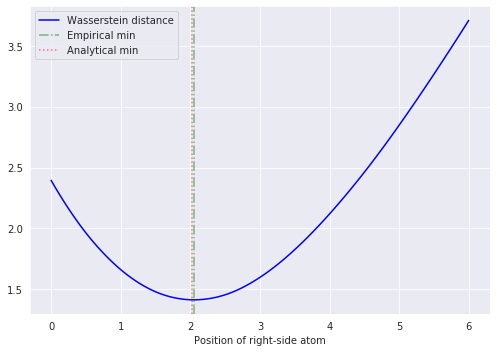

In [5]:
xx = np.linspace(0, 2 * SIGMA, 100)
wass = [f(x) for x in xx]

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(xx, wass, color='b', label='Wasserstein distance')
    ax.axvline(x=x_empirical_1, linestyle='-.', color='g', alpha=0.5, label='Empirical min')
    ax.axvline(x=x_analytical_1, linestyle=':', color='r', alpha=0.5, label='Analytical min')
    ax.legend(loc='upper left')
    ax.set_xlabel('Position of right-side atom')
    plt.tight_layout()
    plt.show()

## 2-Wassertein-distance minimization

$$
\partial_{x_0} W_2(\alpha, \beta)^2 \propto 2\int_{0}^{+\infty} (x_0-x)\phi_{\sigma}(x)dx. 
$$

After collecting terms together and setting this to zero, one gets:
$$
x_0\int_{0}^{+\infty} \phi_{\sigma}(x)dx = \int_{0}^{+\infty} x\phi_{\sigma}(x)dx
$$
i.e 
$$
x_0\sqrt{\frac{\pi}{2}} \sigma = \sigma^2
$$
i.e
$$
x_0 = \sqrt{\frac{2}{\pi}} \sigma.
$$

Note that this yields a different solution than the Gauss-Hermite formula, for which $x_0 = \sigma$.

In [6]:
# Analytical solution
x_analytical_2 = np.sqrt(2 / np.pi) * SIGMA
print('Analytical solution: {:.4f}'.format(x_analytical_2))

# Empirical solution
N =int(1e4)
alpha = SIGMA * np.random.randn(N)
f = lambda x: wasserstein_1d(alpha, [-x, x], p=2)
sol = minimize_scalar(f, method='bounded', bounds=(0, 5))
x_empirical_2 = sol.x
print('Empirical solution: {:.4f}'.format(x_empirical_2))

Analytical solution: 2.3937
Empirical solution: 2.3888


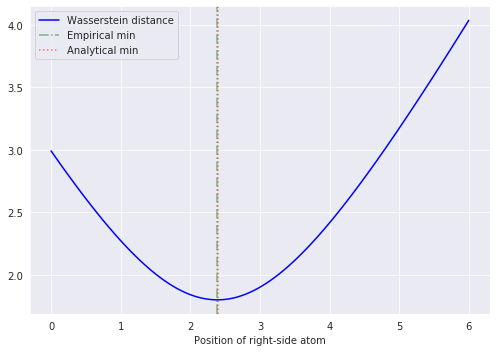

In [7]:
xx = np.linspace(0, 2 * SIGMA, 100)
wass = [f(x) for x in xx]

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(xx, wass, color='b', label='Wasserstein distance')
    ax.axvline(x=x_empirical_2, linestyle='-.', color='g', alpha=0.5, label='Empirical min')
    ax.axvline(x=x_analytical_2, linestyle=':', color='r', alpha=0.5, label='Analytical min')
    ax.legend(loc='upper left')
    ax.set_xlabel('Position of right-side atom')
    plt.tight_layout()
    plt.show()

## Minimization of Kolmogorov-Smirnov distance

As we have seen above, minimizing a Wasserstein distance does not yield the same discretization as the moment-matching technique. We briefly extend this to the minimization of another statistical distance, the Kolmogorov-Smirnov distance, defined by :
$$
d_{KS}(\alpha, \beta) = \sup_{x\in \mathbb{R}} \lvert F_{\alpha}(x) - F_{\beta}(x)\rvert.
$$

It turns out however that minimizing the KS distance yields the same discretization as minimizing the $1$-Wasserstein distance.

In [8]:
N = int(1e4)
tt = np.linspace(-5.0 * SIGMA, 5.0 * SIGMA, N)
def ks_dist(x):
    alpha = norm(loc=0.0, scale=SIGMA)
    xk = [-x, x]
    pk = (0.5, 0.5)
    beta = rv_discrete(values=(xk, pk))
    return np.max(alpha.cdf(tt) - beta.cdf(tt))

f = lambda x: ks_dist(x)
sol = minimize_scalar(f, method='bounded', bounds=(0, 10))
x_empirical_ks = sol.x
print('Empirical solution: {:.4f}'.format(x_empirical_ks))

Empirical solution: 2.0270


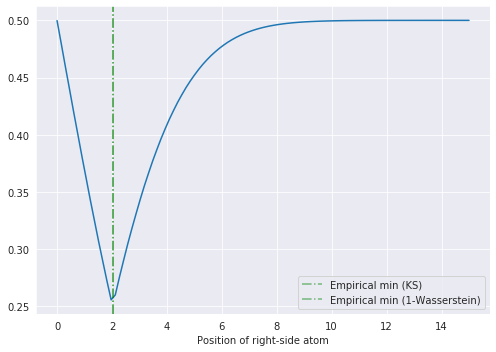

In [9]:
xx = np.linspace(0, 5 * SIGMA, 100)
ks = [f(x) for x in xx]

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(xx, ks)
    ax.axvline(x=x_empirical_ks, linestyle='-.', color='g', alpha=0.5, label='Empirical min (KS)')
    ax.axvline(x=x_empirical_1, linestyle='-.', color='g', alpha=0.5, label='Empirical min (1-Wasserstein)')
    ax.legend(loc='lower right')
    ax.set_xlabel('Position of right-side atom')
    plt.tight_layout()
    plt.show()